# GET POSSIBLE FISH FROM SEGMENTED WELL

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
import cv2 as cv

from skimage import filters, measure, io, segmentation, morphology
from src.well.find_well_props import find_well_props
from src.models import *

from skimage.exposure import equalize_hist

from skimage.morphology import binary_erosion, binary_dilation, binary_opening, convex_hull_image, dilation, erosion,\
    square, disk, remove_small_objects, remove_small_holes
from skimage.color import label2rgb

## Find well props

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________
# Getting bounding box of well
_____________________________________________________________


Text(0.5, 1.0, 'Mask')

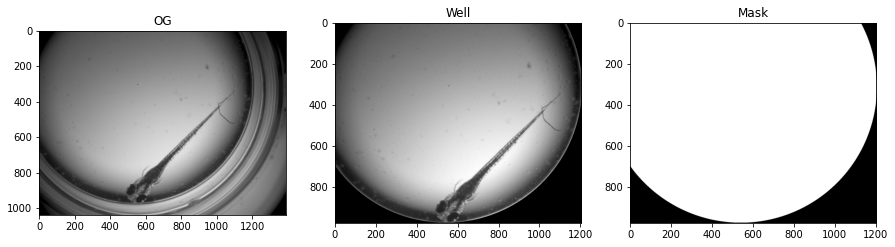

In [15]:
fishy = InputImage('zf1.jpg')

fishy = find_well_props(fishy)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

ax[0].imshow(fishy.og, "gray")
ax[0].set_title('OG')

ax[1].imshow(fishy.processed, "gray")
ax[1].set_title('Well')

ax[2].imshow(fishy.well_props.mask.cropped, "gray")
ax[2].set_title('Mask')

## HPF
couldn't seem to find a good homomoprhic filter

is used an implementation of a high pass filter from 'https://www.geeksforgeeks.org/implement-photoshop-high-pass-filter-hpf-using-opencv-in-python/'

then equalized the resulting image

(array([150299.,   2326.,   2932.,   3499.,   4455.,   3353.,   4415.,
             0.,   6032.,      0.,   8737.,      0.,      0.,  14644.,
             0.,      0.,      0.,      0.,      0.,      0.,  33900.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,  90310.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 192887.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

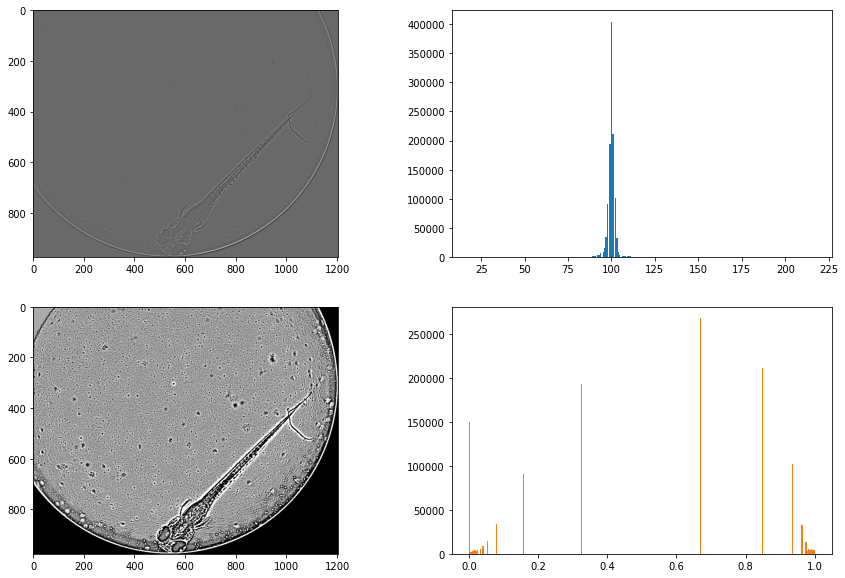

In [16]:
speckless = fishy.well_props.mask.cropped_masked
hpf = speckless - cv.GaussianBlur(speckless, (21, 21), 3) + 100
equalized = equalize_hist(hpf)

equalized = np.multiply(equalized, fishy.well_props.mask.cropped)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].imshow(hpf, 'gray')
ax[0, 1].hist(hpf.ravel(), bins=256)

ax[1, 0].imshow(equalized, 'gray')
ax[1, 1].hist(equalized.ravel(), bins=256)

ax[1, 0].imshow(equalized, 'gray')
ax[1, 1].hist(equalized.ravel(), bins=256)


## Get the binary thresholded image

Yen thresholding

0.974609375


Text(0.5, 1.0, 'bin')

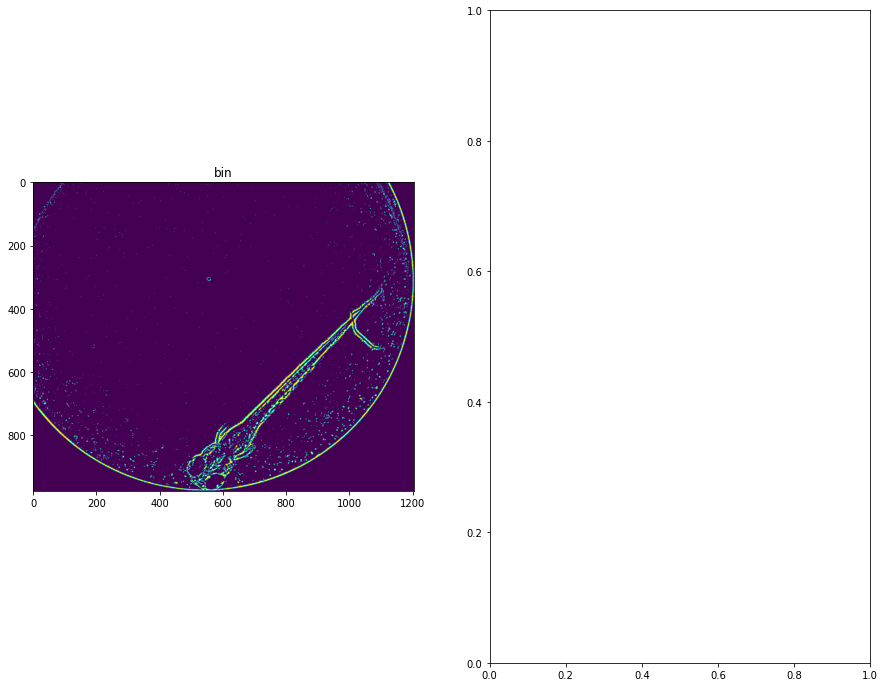

In [17]:
from skimage.filters.thresholding import threshold_yen

thresh = threshold_yen(equalized)

print(thresh)
binary = equalized > thresh
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
ax[0].imshow(binary)
ax[0].set_title('bin')

[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]


Text(0.5, 1.0, 'No speckles')

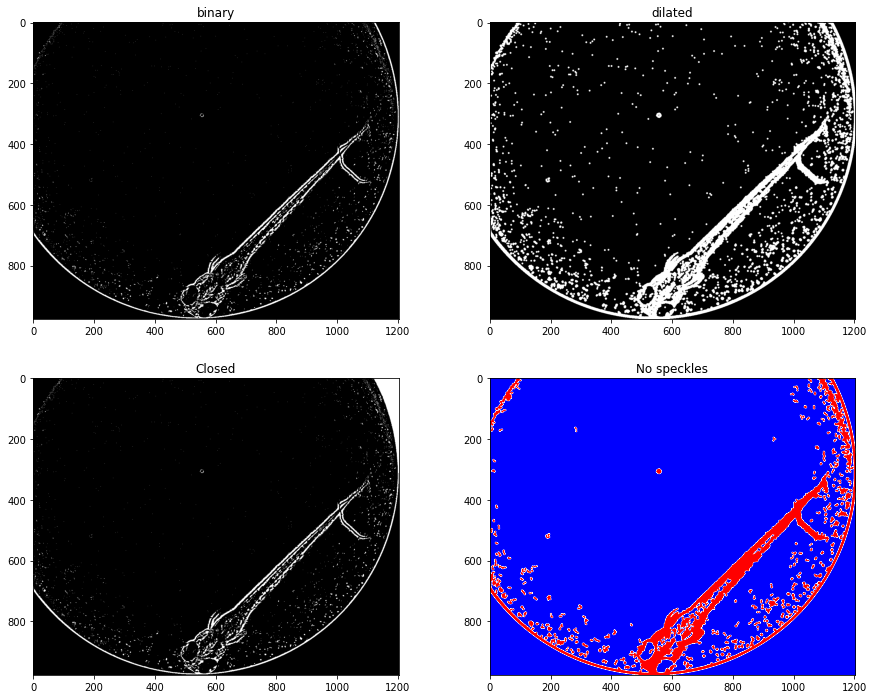

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

se = disk(3)
print(se)

dilated = morphology.binary_dilation(binary, footprint=se)
eroded = morphology.binary_erosion(dilated)

# closed = morphology.binary_closing(binary)
size = fishy.well_props.mask.cropped_masked.size * 0.1
closed = morphology.area_closing(binary, size)

no_speckles = remove_small_objects(remove_small_holes(dilated, connectivity=np.ndim(dilated), area_threshold=100))

ax[0, 0].imshow(binary, 'gray')
ax[0, 0].set_title('binary')

ax[0, 1].imshow(dilated, 'gray')
ax[0, 1].set_title('dilated')

ax[1, 0].imshow(closed, 'gray')
ax[1, 0].set_title('Closed')

ax[1, 1].imshow(no_speckles, 'bwr')
ax[1, 1].set_title('No speckles')

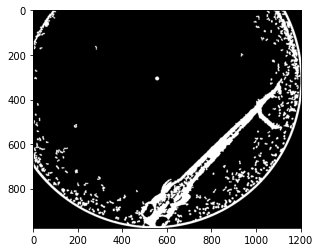

In [19]:
fishy.binary = no_speckles.copy()
plt.imshow(no_speckles, 'gray')
plt.show()

In [20]:
def get_meniscus(input_img: InputImage, corrected=False):
    binary_img = input_img.binary
    well_mask = input_img.well_props.mask.cropped

    if binary_img.shape != well_mask.shape:
        raise Exception("Arguments 'binary_img' and 'well_mask' must have equal shape" +
                        f"\n'binary_img': {binary_img.shape} != 'well_mask': {well_mask.shape}")

    possible_well_size_th = np.zeros_like(binary_img)
    remaining_binary_img = binary_img

    if not corrected:
        structuring_element = disk(21)
        eroded_well = erosion(well_mask, structuring_element)
        remaining_binary_img[np.where(eroded_well > 0)] = 0
    #    remaining_binary_img = morphology.area_opening(remaining_binary_img, 100)

    mh, mw = binary_img.shape
    h_center, w_center = int(mh / 2), int(mw / 2)

    lt = remaining_binary_img[0:h_center, 0:w_center]
    lb = remaining_binary_img[h_center:mh, 0:w_center]
    rt = remaining_binary_img[0:h_center, w_center:mw]
    rb = remaining_binary_img[h_center:mh, w_center:mw]

    """lt_thresh = get_mean_col_sum_for_structuring_element(lt, "lt", corrected)
    lb_thresh = get_mean_col_sum_for_structuring_element(lb, "lb", corrected)
    rt_thresh = get_mean_col_sum_for_structuring_element(rt, "rt", corrected)
    rb_thresh = get_mean_col_sum_for_structuring_element(rb, "rb", corrected)"""

    left_side = np.concatenate((lt, lb), axis=0)
    right_side = np.concatenate((rt, rb), axis=0)
    full = np.concatenate((left_side, right_side), axis=1)

    return full

Text(0.5, 1.0, 'removed_menisc')

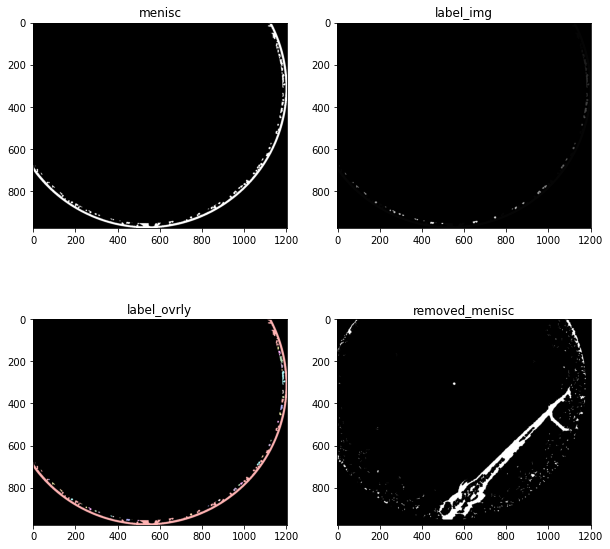

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

binarey = no_speckles.copy()
mask = fishy.well_props.mask.cropped

menisc = get_meniscus(fishy)
menisc = binary_opening(menisc, square(2))

label_img = measure.label(menisc, connectivity=menisc.ndim)
label_ovrly = label2rgb(label_img, image=menisc)

se = disk(3)

# c  = binary_erosion(c, se)

removed_menisc = binarey.copy()
removed_menisc[np.where(menisc > 0)] = 0
removed_menisc = binary_erosion(removed_menisc, se)

ax[0, 0].imshow(menisc, 'gray')
ax[0, 0].set_title('menisc')

ax[0, 1].imshow(label_img, 'gray')
ax[0, 1].set_title('label_img')

ax[1, 0].imshow(label_ovrly, 'gray')
ax[1, 0].set_title('label_ovrly')

ax[1, 1].imshow(removed_menisc, 'gray')
ax[1, 1].set_title('removed_menisc')

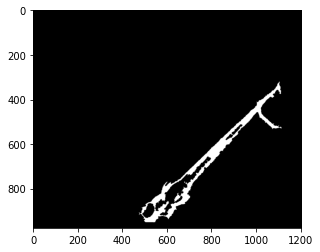

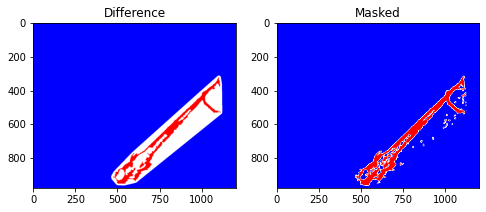

In [22]:
removed_objects = morphology.area_opening(removed_menisc, area_threshold=removed_menisc.nonzero()[0].size * 0.1,
                                          connectivity=removed_menisc.ndim)  # Removing holes

convex = convex_hull_image(removed_objects)
convex = binary_dilation(convex, disk(10))
fish_masked = removed_objects * convex

fishy.fish_props.mask.og = convex
fishy.fish_props.mask.masked = fish_masked

plt.imshow(fishy.processed, 'gray')
plt.imshow(fish_masked, 'gray')
from skimage import img_as_float

chull_diff = img_as_float(convex)
chull_diff[fish_masked] = 2

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(chull_diff, 'bwr')
ax[0].set_title('Difference')

ax[1].imshow(binarey * convex, 'bwr')
ax[1].set_title('Masked')

fishy.fish_props.mask.og = convex
fishy.fish_props.mask.masked = binarey * convex

plt.show()

Text(0.5, 1.0, 'removed_menisc')

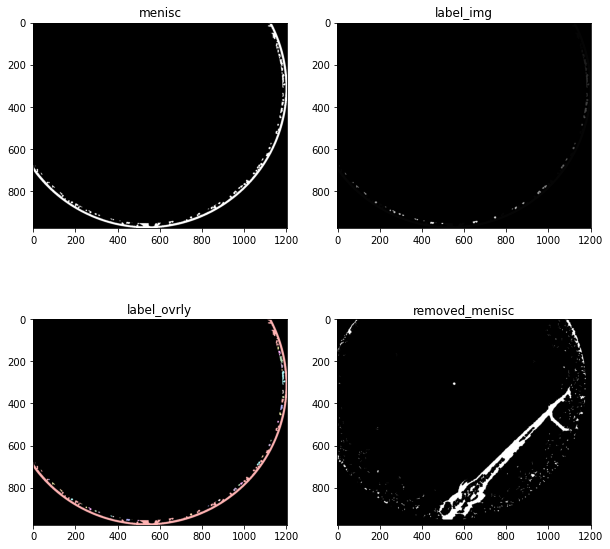

In [23]:
from skimage.morphology import binary_erosion, binary_opening, convex_hull_image
from skimage.color import label2rgb

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

binarey = no_speckles.copy()
fishy.binary = binarey.copy()
mask = fishy.well_props.mask.cropped.copy()

menisc = get_meniscus(fishy)
menisc = binary_opening(menisc, square(2))

label_img = measure.label(menisc, connectivity=menisc.ndim)
label_ovrly = label2rgb(label_img, image=menisc)

se = disk(3)

# c  = binary_erosion(c, se)

removed_menisc = binarey.copy()
removed_menisc[np.where(menisc > 0)] = 0
removed_menisc = binary_erosion(removed_menisc, se)

ax[0, 0].imshow(menisc, 'gray')
ax[0, 0].set_title('menisc')

ax[0, 1].imshow(label_img, 'gray')
ax[0, 1].set_title('label_img')

ax[1, 0].imshow(label_ovrly, 'gray')
ax[1, 0].set_title('label_ovrly')

ax[1, 1].imshow(removed_menisc, 'gray')
ax[1, 1].set_title('removed_menisc')

## Separating Fishy


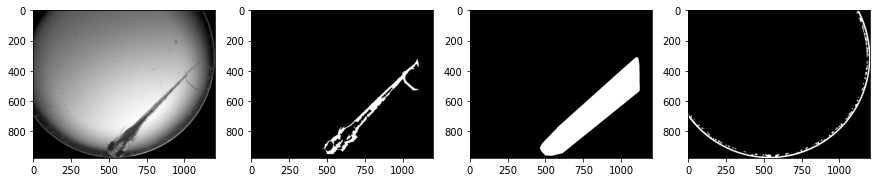

In [24]:
from skimage.morphology import binary_dilation
from skimage import img_as_float

chull_diff = img_as_float(convex)
chull_diff[fish_masked] = 2

removed_objects = morphology.area_opening(removed_menisc, area_threshold=removed_menisc.nonzero()[0].size * 0.1,
                                          connectivity=removed_menisc.ndim)  # Removing holes

convex = convex_hull_image(removed_objects)
convex = binary_dilation(convex, disk(10))
fish_masked = removed_objects * convex

fishy.fish_props.mask.og = convex
fishy.fish_props.mask.masked = fish_masked

fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax = ax.ravel()

ax[0].imshow(fishy.processed, 'gray')
ax[1].imshow(fish_masked, 'gray')
ax[2].imshow(convex, 'gray')
ax[3].imshow(fishy.binary, 'gray')

## Getting fish mask


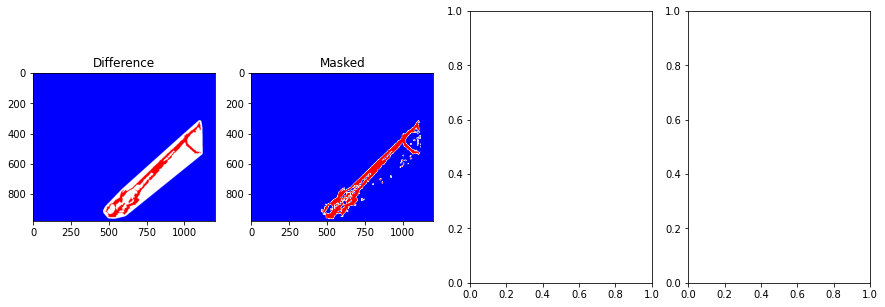

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax = ax.ravel()

ax[0].imshow(chull_diff, 'bwr')
ax[0].set_title('Difference')

ax[1].imshow(binarey * convex, 'bwr')
ax[1].set_title('Masked')

fishy.fish_props.mask.og = convex
fishy.fish_props.mask.masked = binarey * convex

plt.show()

# FIN
___________________________________________________

In [26]:
def get_mean_col_sum_for_structuring_element(data: np.ndarray, corner: str, corrected_step: bool = False):  #cont, mod_cont
    thresh_well = np.zeros_like(data.shape)

    col_sum = np.sum(data[-1:1])  # in matlab ->   data'
    mean_data = np.floor(np.mean(col_sum[(col_sum > 0)]))
    """
        if not corrected_step:
            img = cont
        else:
            img = mod_cont
    """
    if not np.isnan(mean_data):
        structuring_element = disk(mean_data)
        if corner == 'lt':
            thresh_well = dilation(
                speckless[0:np.floor(speckless.shape[0] / 2), 0:np.floor(speckless.shape[1] / 2)],
                structuring_element)
        elif corner == 'lb':
            thresh_well = dilation(
                speckless[np.floor(speckless.shape[0] / 2):speckless.shape[0], 0:np.floor(speckless.shape[1] / 2)],
                structuring_element)
        elif corner == 'rt':
            thresh_well = dilation(
                speckless[0:np.floor(speckless.shape[0] / 2), np.floor(speckless.shape[1] / 2):speckless.shape[1]],
                structuring_element)
        elif corner == 'rb':
            thresh_well = dilation(
                speckless[np.floor(speckless.shape[0] / 2):speckless.shape[0],
                np.floor(speckless.shape[1] / 2):speckless.shape[1]],
                structuring_element)

    return thresh_well

In [27]:
def get_meniscus(input_img: InputImage, corrected=False):
    binary_img = input_img.binary
    well_mask = input_img.well_props.mask.cropped

    if binary_img.shape != well_mask.shape:
        raise Exception("Arguments 'binary_img' and 'well_mask' must have equal shape" +
                        f"\n'binary_img': {binary_img.shape} != 'well_mask': {well_mask.shape}")

    possible_well_size_th = np.zeros_like(binary_img)
    remaining_binary_img = binary_img

    if not corrected:
        structuring_element = disk(21)
        eroded_well = erosion(well_mask, structuring_element)
        remaining_binary_img[np.where(eroded_well > 0)] = 0
    #    remaining_binary_img = morphology.area_opening(remaining_binary_img, 100)

    mh, mw = binary_img.shape
    h_center, w_center = int(mh / 2), int(mw / 2)

    lt = remaining_binary_img[0:h_center, 0:w_center]
    lb = remaining_binary_img[h_center:mh, 0:w_center]
    rt = remaining_binary_img[0:h_center, w_center:mw]
    rb = remaining_binary_img[h_center:mh, w_center:mw]

    lt_thresh = get_mean_col_sum_for_structuring_element(lt, "lt", corrected)
    lb_thresh = get_mean_col_sum_for_structuring_element(lb, "lb", corrected)
    rt_thresh = get_mean_col_sum_for_structuring_element(rt, "rt", corrected)
    rb_thresh = get_mean_col_sum_for_structuring_element(rb, "rb", corrected)

    left_side = np.concatenate((lt, lb), axis=0)
    right_side = np.concatenate((rt, rb), axis=0)
    full = np.concatenate((left_side, right_side), axis=1)

    return full  # [lt, rt, lb, rb]

In [28]:
def get_meniscus_(binary_img: np.ndarray, mask: np.ndarray, corrected=False) -> np.ndarray:
    if binary_img.shape != mask.shape:
        raise Exception("Arguments 'binary_img' and 'well_mask' must have equal shape" +
                        f"\n'binary_img': {binary_img.shape} != 'well_mask': {mask.shape}")

    possible_well_size_th = np.zeros_like(binary_img)
    remaining_binary_img = binary_img

    if not corrected:
        structuring_element = disk(21)
        eroded_well = erosion(mask, structuring_element)
        remaining_binary_img[np.where(eroded_well > 0)] = 0
    #    remaining_binary_img = morphology.area_opening(remaining_binary_img, 100)

    mh, mw = binary_img.shape
    h_center, w_center = int(mh / 2), int(mw / 2)

    lt = remaining_binary_img[0:h_center, 0:w_center]
    lb = remaining_binary_img[h_center:mh, 0:w_center]
    rt = remaining_binary_img[0:h_center, w_center:mw]
    rb = remaining_binary_img[h_center:mh, w_center:mw]

    """lt_thresh = get_mean_col_sum_for_structuring_element(lt, "lt", corrected)
    lb_thresh = get_mean_col_sum_for_structuring_element(lb, "lb", corrected)
    rt_thresh = get_mean_col_sum_for_structuring_element(rt, "rt", corrected)
    rb_thresh = get_mean_col_sum_for_structuring_element(rb, "rb", corrected)"""

    left_side = np.concatenate((lt, lb), axis=0)
    right_side = np.concatenate((rt, rb), axis=0)
    full = np.concatenate((left_side, right_side), axis=1)

    return full


In [34]:
lala = np.arange(25).reshape(5,5)

SyntaxError: EOL while scanning string literal (3647734649.py, line 2)

# SOBEL EDGE DETECTION

In [29]:
ddepth = cv.CV_16S
grad_x = cv.Sobel(src=fishy.well_props.mask.cropped_masked, ddepth=ddepth, dx=1, dy=0, ksize=4)
grad_y = cv.Sobel(src=fishy.well_props.mask.cropped_masked, ddepth=ddepth, dx=0, dy=1, ksize=4)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(grad_x, 'gray')
ax[1].imshow(grad_y, 'gray')


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\deriv.cpp:104: error: (-211:One of the arguments' values is out of range) The kernel size must be odd and not larger than 31 in function 'cv::getSobelKernels'


In [ ]:
abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)

grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

eq_grad = equalize_hist(grad)  # Equalizing values for better separation

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(eq_grad.ravel(), 255)
ax[1].imshow(eq_grad, 'gray')

In [ ]:
trsh = (eq_grad > threshold_yen(eq_grad))
plt.imshow(trsh, "gray")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
obj = remove_small_objects(trsh, size*0.1)
hole = remove_small_holes(obj)

hole = np.uint8(hole)

ax[0].imshow(obj, "gray")
ax[1].imshow(hole, "gray")

In [ ]:
a = get_meniscus_(hole, fishy.well_props.mask.cropped)

plt.imshow(a, 'gray')
